## Sentiment Analysis

In this exercise we use the IMDb-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

**(a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing. Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

reviews = pd.read_csv('reviews.txt', header=None)[0]
labels = pd.read_csv('labels.txt', header=None)[0]
Y = (labels == 'positive').astype(np.int_)

# 60/20/20
X_temp, X_test, y_temp, y_test = train_test_split(reviews, Y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Bag-of-Words representation
vectorizer = CountVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

print("Train shape:", X_train_vec.shape)
print("Validation shape:", X_val_vec.shape)
print("Test shape:", X_test_vec.shape)

# todo: Stopword Removal: Remove common words (e.g., "the", "and")

Train shape: (15000, 10000)
Validation shape: (5000, 10000)
Test shape: (5000, 10000)


**(b)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sample_index = 0
sample_text = X_train.iloc[sample_index]
sample_vector = X_train_vec[sample_index].toarray()[0]

print("Word counts in first review:")
nonzero_indices = sample_vector.nonzero()[0]
for idx in nonzero_indices:
    word = vectorizer.get_feature_names_out()[idx]
    count = sample_vector[idx]
    print(f"{word}: {count}")

Word counts in first review:
about: 1
actually: 1
among: 1
an: 1
and: 9
another: 2
appear: 1
arrive: 1
as: 5
at: 1
back: 1
be: 1
beat: 1
beatles: 3
been: 1
beginning: 1
being: 1
best: 2
birth: 3
blockbusters: 1
but: 1
by: 4
can: 1
care: 1
carpenter: 1
cast: 1
charming: 1
clark: 1
critics: 1
dick: 1
did: 3
direct: 2
directed: 1
director: 2
earlier: 1
ed: 1
edge: 1
elvis: 1
ends: 1
entire: 1
era: 1
escape: 1
especially: 1
essence: 1
excellent: 1
eye: 1
fall: 1
far: 1
film: 4
for: 4
former: 1
four: 2
from: 3
gives: 1
had: 2
halloween: 1
hardships: 1
has: 2
have: 1
he: 1
highly: 1
however: 1
in: 8
industry: 1
is: 3
it: 2
jedi: 1
john: 2
know: 1
kurt: 1
lead: 1
legend: 3
lennon: 1
life: 1
long: 1
many: 1
most: 1
movie: 4
movies: 1
mr: 2
music: 1
musical: 1
named: 1
needle: 1
new: 1
nor: 1
not: 2
nyc: 1
of: 17
on: 2
only: 1
other: 3
paul: 1
performance: 2
pete: 1
point: 1
produced: 2
public: 1
recommend: 1
release: 1
released: 1
return: 1
richard: 1
rock: 1
rod: 1
role: 1
roll: 1
said: 1
sam

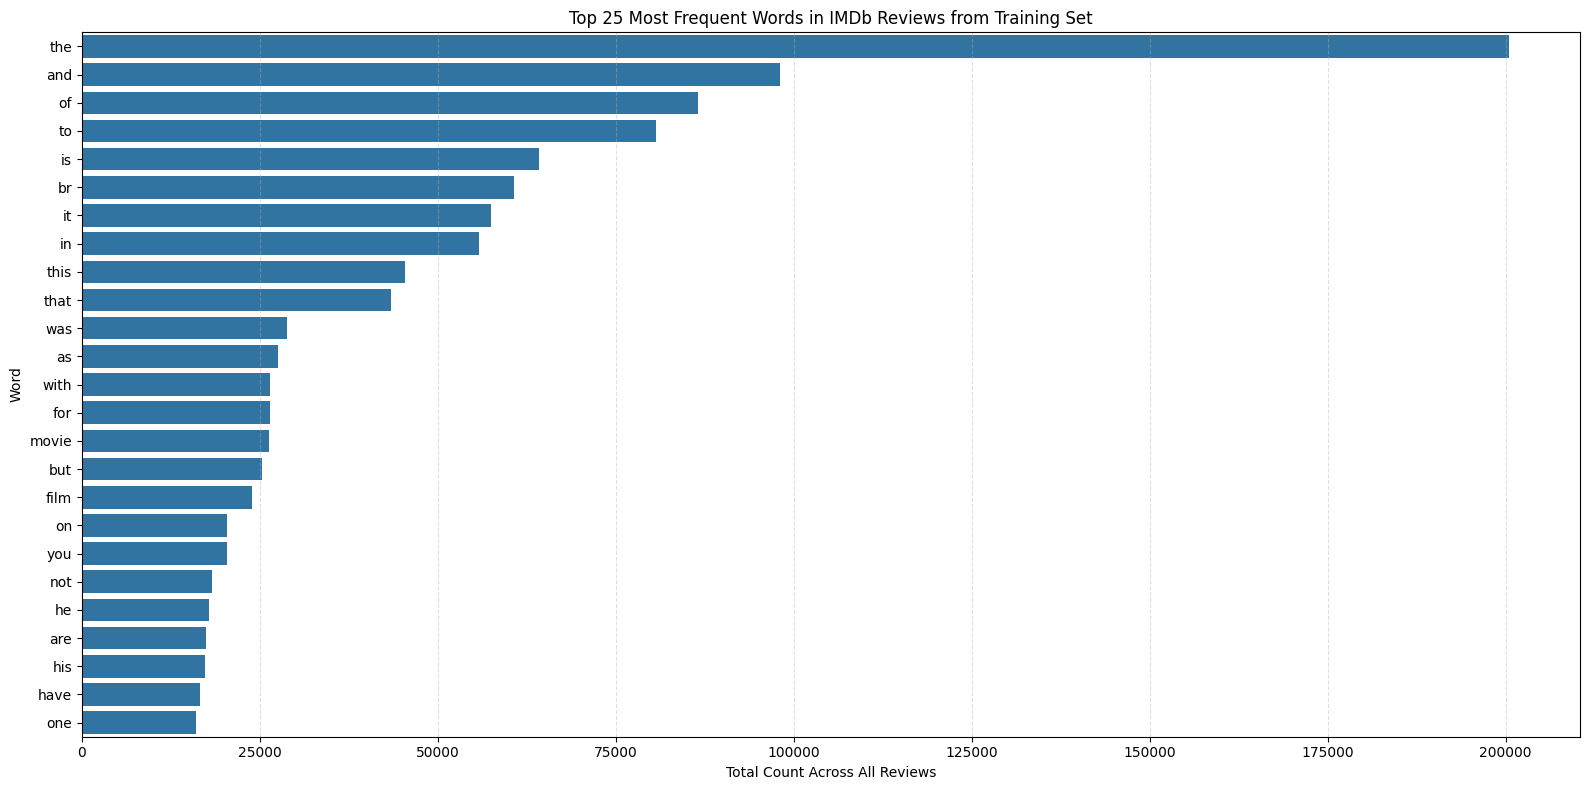

In [4]:
word_sums = np.asarray(X_train_vec.sum(axis=0)).flatten()
top_100_idx = word_sums.argsort()[::-1][:25]
top_100_words = vectorizer.get_feature_names_out()[top_100_idx]
top_100_counts = word_sums[top_100_idx]

plt.figure(figsize=(16, 8))
sns.barplot(x=top_100_counts, y=top_100_words)
plt.title("Top 25 Most Frequent Words in IMDb Reviews from Training Set")
plt.xlabel("Total Count Across All Reviews")
plt.ylabel("Word")
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

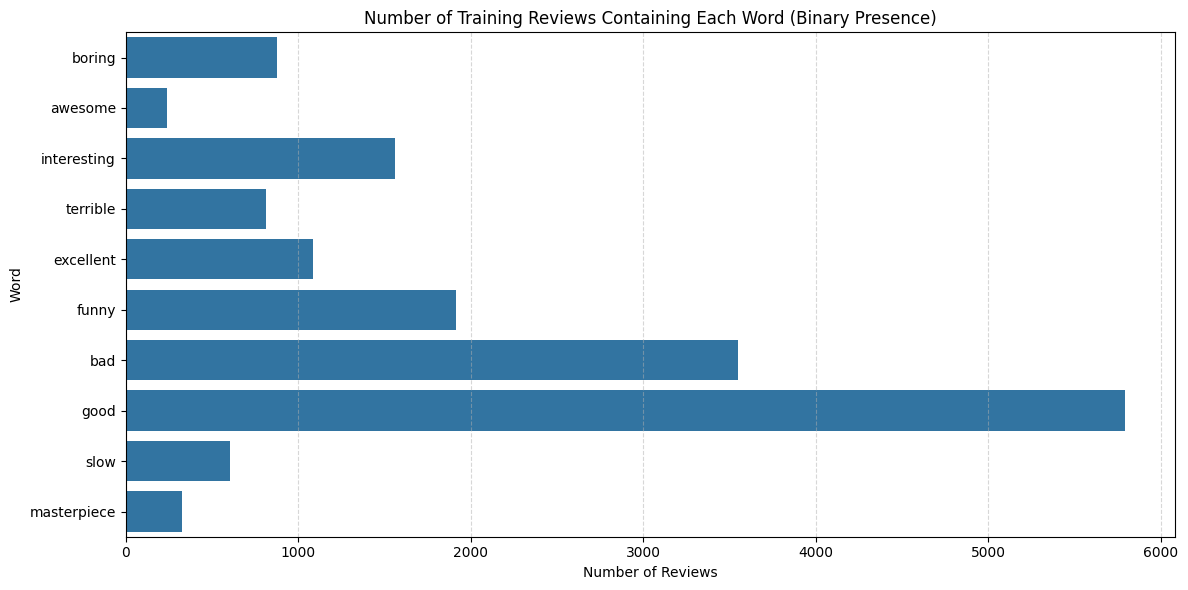

In [5]:
def count_reviews_with_word(word, vectorizer, X_bow):
    idx = vectorizer.vocabulary_.get(word)
    if idx is not None:
        binary_column = (X_bow[:, idx] > 0).toarray().flatten()
        count = binary_column.sum()
        return count
    else:
        return None

words = ['boring', 'awesome', 'interesting', 'terrible', 'excellent', 'funny', 'bad', 'good', 'slow', 'masterpiece']

review_counts = []
valid_words = []

for word in words:
    count = count_reviews_with_word(word, vectorizer, X_train_vec)
    if count is not None:
        valid_words.append(word)
        review_counts.append(count)

plt.figure(figsize=(12, 6))
sns.barplot(x=review_counts, y=valid_words)
plt.title("Number of Training Reviews Containing Each Word (Binary Presence)")
plt.xlabel("Number of Reviews")
plt.ylabel("Word")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [6]:
nonzero_elements = X_train_vec.count_nonzero()
total_elements = X_train_vec.shape[0] * X_train_vec.shape[1]
sparsity = 100 * (1 - nonzero_elements / total_elements)
print(f"Emptiness of the BoW matrix: {sparsity}")

Emptiness of the BoW matrix: 98.74498533333333


**(c)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy. 

In [7]:
from keras import Sequential
from keras.src.callbacks import EarlyStopping
import pandas as pd
from itertools import product
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input

X_train_dense = X_train_vec.toarray()
X_val_dense = X_val_vec.toarray()
X_test_dense = X_test_vec.toarray()

hidden_units_list = [64, 128, 256]
dropout_rates = [0.3, 0.4, 0.5]
learning_rates = [1e-3, 1e-4]

results = []
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=2,
                           restore_best_weights=True)

for hidden_units, dropout, lr in product(hidden_units_list, dropout_rates, learning_rates):
    print(f"\nTraining model: hidden={hidden_units}, dropout={dropout}, lr={lr}")
    
    model = Sequential([
        Input(shape=(X_train_dense.shape[1],)),  # number of features 10000
        Dense(hidden_units),
        Dropout(dropout),
        Dense(1, activation='relu')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    history = model.fit(
        X_train_dense, y_train,
        validation_data=(X_val_dense, y_val),
        epochs=10,
        batch_size=64, #The training data is divided into batches of 64 samples
        callbacks=[early_stop],
        verbose=0
    )
    
    # Store results for each epoch
    for epoch, (acc, val_acc) in enumerate(zip(history.history['accuracy'], history.history['val_accuracy']), start=1):
        results.append({
            'hidden_units': hidden_units,
            'dropout': dropout,
            'learning_rate': lr,
            'epoch': epoch,
            'accuracy': acc,
            'val_accuracy': val_acc
        })


Training model: hidden=64, dropout=0.3, lr=0.001

Training model: hidden=64, dropout=0.3, lr=0.0001

Training model: hidden=64, dropout=0.4, lr=0.001

Training model: hidden=64, dropout=0.4, lr=0.0001

Training model: hidden=64, dropout=0.5, lr=0.001

Training model: hidden=64, dropout=0.5, lr=0.0001

Training model: hidden=128, dropout=0.3, lr=0.001

Training model: hidden=128, dropout=0.3, lr=0.0001

Training model: hidden=128, dropout=0.4, lr=0.001

Training model: hidden=128, dropout=0.4, lr=0.0001

Training model: hidden=128, dropout=0.5, lr=0.001

Training model: hidden=128, dropout=0.5, lr=0.0001

Training model: hidden=256, dropout=0.3, lr=0.001

Training model: hidden=256, dropout=0.3, lr=0.0001

Training model: hidden=256, dropout=0.4, lr=0.001

Training model: hidden=256, dropout=0.4, lr=0.0001

Training model: hidden=256, dropout=0.5, lr=0.001

Training model: hidden=256, dropout=0.5, lr=0.0001


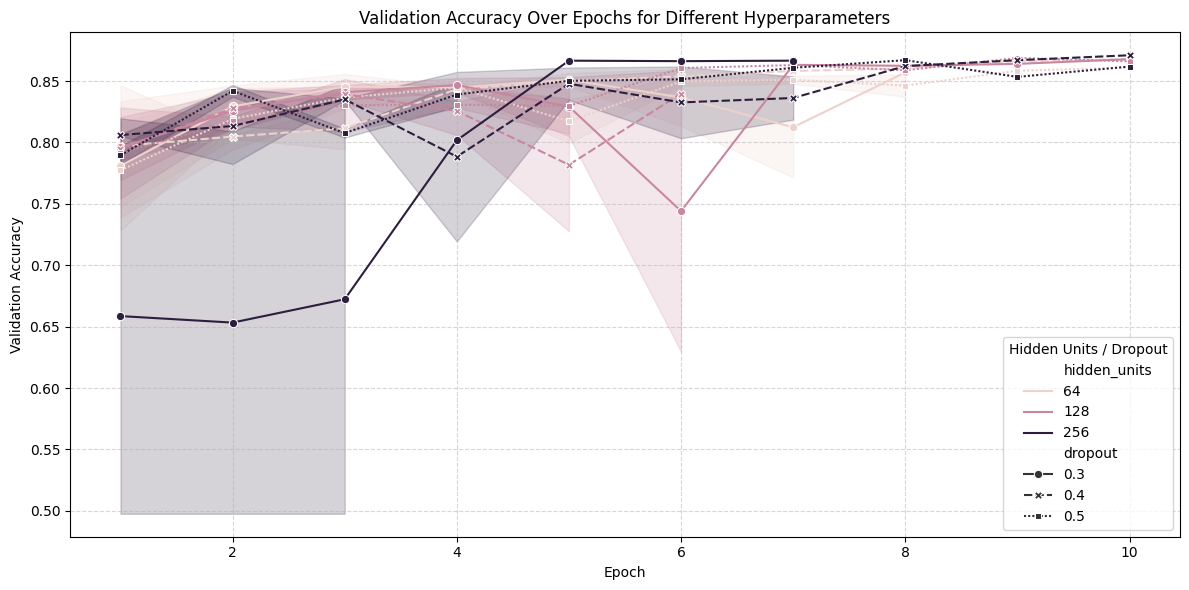

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


results_df = pd.DataFrame(results)
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='epoch', y='val_accuracy', hue='hidden_units', style='dropout', markers=True)

plt.title('Validation Accuracy Over Epochs for Different Hyperparameters')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(title='Hidden Units / Dropout')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

In [9]:
import numpy as np

best_model_params = results_df.loc[results_df['val_accuracy'].idxmax()]
print("Best Model Parameters:")
print(best_model_params)

Best Model Parameters:
hidden_units     256.0000
dropout            0.4000
learning_rate      0.0001
epoch             10.0000
accuracy           0.9190
val_accuracy       0.8710
Name: 114, dtype: float64


**(d)** Test your sentiment-classifier on the test set.

In [10]:
best_hidden_units = int(best_model_params['hidden_units'])
best_dropout = float(best_model_params['dropout'])
best_learning_rate = float(best_model_params['learning_rate'])

X_combined = np.vstack((X_train_dense, X_val_dense))
y_combined = np.hstack((y_train, y_val))

best_model = Sequential([
    Input(shape=(X_combined.shape[1],)),
    Dense(best_hidden_units),
    Dropout(best_dropout),
    Dense(1, activation='relu')
])

best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_learning_rate),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

best_model.fit(X_combined, y_combined, epochs=10, batch_size=64, verbose=1)

test_loss, test_accuracy = best_model.evaluate(X_test_dense, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6467 - loss: 2.3890
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8227 - loss: 1.2019
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8544 - loss: 0.9179
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8724 - loss: 0.8281
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8889 - loss: 0.7157
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8972 - loss: 0.6676
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8755 - loss: 0.9179
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9133 - loss: 0.6129
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9024 - loss: 0.6920
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9174 - loss: 0.5465
Test Accuracy: 0.8592


**(e)** Use the classifier to classify a few sentences you write yourselves. 

In [11]:
custom_sentences = [
    "The movie was absolutely fantastic!",
    "I found the plot to be very boring and predictable.",
    "What a masterpiece! Truly a work of art.",
    "The acting was terrible, and the story made no sense.",
    "It was a good movie with some great performances.",
    "Eu sunt cel mai rau elev din clasa noastra.",
    "I am the worst student in our class.",
]

custom_sentences_vec = vectorizer.transform(custom_sentences).toarray()
predictions = best_model.predict(custom_sentences_vec)
predicted_labels = (predictions > 0.5).astype(int).flatten()

for sentence, label in zip(custom_sentences, predicted_labels):
    sentiment = "Positive" if label == 1 else "Negative"
    print(f"Sentence: \"{sentence}\" -> Sentiment: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Sentence: "The movie was absolutely fantastic!" -> Sentiment: Negative
Sentence: "I found the plot to be very boring and predictable." -> Sentiment: Negative
Sentence: "What a masterpiece! Truly a work of art." -> Sentiment: Negative
Sentence: "The acting was terrible, and the story made no sense." -> Sentiment: Negative
Sentence: "It was a good movie with some great performances." -> Sentiment: Negative
Sentence: "Eu sunt cel mai rau elev din clasa noastra." -> Sentiment: Negative
Sentence: "I am the worst student in our class." -> Sentiment: Negative
